# LTCF application

```{cointents} Table of Contents
:depth: 3
```


"https://academic.oup.com/cid/article/74/1/113/6370508#google_vignette"

LTCFs have a high burden of norovirus outbreaks. Most LTCF norovirus outbreaks occurred during winter months and were spread person-to-person. Outbreak surveillance can inform development of interventions for this vulnerable population, such as vaccines targeting GII.4 norovirus strains.

For every 1000 cases, there were 21.6 hospitalizations and 2.3 deaths.


"https://www.sciencedirect.com/science/article/pii/S1755436523000075"




## Guided model building 

1. What populations should we consider?
2. Is this type of pathogen seasonal and recurring?
3. Do we expect different rates of commuting between specific populations? 
4. Can we visualize our model?
5. Can we write down the system of differential equations?
6. Can we code it?
7. Can we infer anything important from our model results? 


## Focusing first on movement of individuals

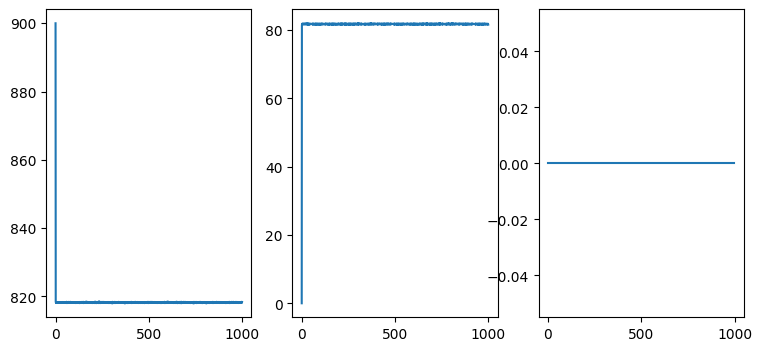

In [125]:

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


#-Population X is residents of a LTCF (Location X is the LTCF))
#-Population Y is clinical staff      (Location Y is the hospital)



def model():
    def metapop(t, y
                    ,new_resident_enters_ltcf
                    ,new_clinician_is_hired
                    ,residents_come_back_from_hospital
                    ,residents_go_to_hospital
                    ,clinicians_come_back_to_hospital
                    ,clinicians_go_to_LTCF):
        Nxx,Nxy,Nxz, Nyy, Nyx,Nyz, Nzz, Nzx, Nzy = y

       
        #-- This piece first-----------------------------------------------------------------------
        #--residents of LTCF
        dNxx_dt    = residents_come_back_from_hospital * Nxy - residents_go_to_hospital * Nxx - resident_and_staff_mingle*Nxx + resident_no_long_mingles*Nxz
        dNxy_dt    = -residents_come_back_from_hospital * Nxy + residents_go_to_hospital * Nxx
        dNxz_dt    = resident_and_staff_mingle*Nxx - resident_no_long_mingles*Nxz

        
        #--Clinical Staff
        dNyy_dt    = clinicians_come_back_to_hospital * Nyx - clinicians_go_to_LTCF * Nyy 
        dNyx_dt    = -clinicians_come_back_to_hospital * Nyx + clinicians_go_to_LTCF * Nyy
        dNyz_dt    = 0

        
        #--LTCF Staff
        dNzz_dt    = -resident_and_staff_mingle*Nzz + staff_to_staff*Nzx 
        dNzx_dt    = resident_and_staff_mingle*Nzz  - staff_to_staff*Nzx
        dNzy_dt    = 0
        
        #----------------------------------------------------------------------------------------
        
        return [ dNxx_dt, dNxy_dt, dNxz_dt
                ,dNyy_dt, dNyx_dt, dNyz_dt
                ,dNzz_dt, dNzx_dt, dNzy_dt ] 
    
    # Parameters
    new_resident_enters_ltcf = 0.#1./4
    new_clinician_is_hired   = 0.#1./52
    
    residents_come_back_from_hospital = 0#10.
    residents_go_to_hospital          = 0#1.

    clinicians_come_back_to_hospital  = 0#1.
    clinicians_go_to_LTCF             = 0#1.

    resident_and_staff_mingle         = 1
    resident_no_long_mingles          = 1
    staff_to_staff                    = 10
    
    
    Nxx, Nyy, Nzz                = 600, 10, 900   # Population sizes
    Nxy, Nxz, Nyx, Nyz, Nzx, Nzy =   0, 0, 0, 0, 0, 0 # Population sizes

    y0 = [Nxx,Nxy,Nxz,Nyy,Nyx,Nyz,Nzz,Nzx,Nzy]
    
    # Time span
    t_span = (0, 500)  # 100 days
    t_eval = np.linspace(*t_span, (t_span[-1]-t_span[0])*2 )
    
    # Solve the system
    solution = solve_ivp(metapop
                         , t_span
                         , y0
                         , args   = (new_resident_enters_ltcf
                                    ,new_clinician_is_hired
                                    ,residents_come_back_from_hospital
                                    ,residents_go_to_hospital
                                    ,clinicians_come_back_to_hospital
                                    ,clinicians_go_to_LTCF)
                         , t_eval = t_eval)
    return solution 
    

# Plot results
fig,axs = plt.subplots( 1,3, figsize=(9, 4))

solution = model()


Nx = solution.y[6]
Ny = solution.y[7] 
Nz = solution.y[8] 

ax=axs[0]
ax.plot(Nx)

ax=axs[1]
ax.plot(Ny)

ax=axs[2]
ax.plot(Nz)


## 

### Fixed points for just movement

We observed above that the dynamics quickly move towards a set number of values and then stay there. 
In other words, the number of individuals in each of the "locations" reach a steady state---a fixed point.

Lets see if we can figure out the fixed points **just** for the movement of individuals between two locations: locations "x" and "y". 
For this exercise it is enough to understand the number of individuals from location who stay there and who move to location y or 

\begin{align}
    \frac{dN_{xx} }{dt} &= -\alpha N_{xx} + \beta N_{xy} \\
    \frac{dN_{xy} }{dt} &=  \alpha N_{xx} - \beta N_{xy} \\
\end{align}

To find the fixed points we set these two derivaties to zero. 

\begin{align}
    -\alpha N_{xx} + \beta N_{xy} &=0 \\
    \alpha N_{xx} - \beta N_{xy}  &=0 \\
\end{align}

and find that 

\begin{align}
    N_{xx}  = \frac{\beta}{\alpha} N_{xy}
\end{align}

This isnt a single point.
Instead, this is an infinite number of fixed points. 
This is because the two derivatives above are redundant (ie we would arrive at the same solution above no matter which equation we solved). 

If we had another constraint on the number of individuals in XX and in XY then we could find a single, unique fixed point. 
We are forgetting an important constraint.

\begin{align}
    N_{x} = N_{xx} + N_{xy}
\end{align}

The number of individuals who originate from location $X$ must be the sum of those who stay in X and moved to Y. 

Lets see if we can use this constraint to help us. 

\begin{align}
    N_{xx}  &= \frac{\beta}{\alpha} N_{xy} \\ 
            &= \frac{\beta}{\alpha} \left( N_{x} - N_{xx} \right)\\
   (1 + \frac{\beta}{\alpha})N_{xx}  &= \frac{\beta}{\alpha} N_{x} \\ 
   N_{xx} &= \frac{ \frac{\beta}{\alpha} N_{x} }{ (1 + \frac{\beta}{\alpha})} \\ 
   N_{xx} &= \left(\frac{\beta }{ \alpha + \beta}\right) N_{x} 
\end{align}

We find that the rate of movement to location Y $(\alpha)$ and the rate of movement back to $X$ ($\beta$) result in a fixed point such that there is a constant proportion $(\beta / (\alpha + \beta))$ of individuals in $N_{xx}$ and a proportion $(\alpha / (\alpha + \beta))$ of individuals in $N_{xy}$.

**How can we use this information?**
Rather than ask for the rate of movement of individuals between the LTCF and hospital, we can ask "what proportion of your clinical staff is assigned to the LTCF for any given time period?".


## A potential metapopulation model for a long-term care facility. 

Our goal is to model the number of infections over time among three groups of humans who interact at the same long-term care facility (LTCF): 1. residents at the LTCF, 2. clinicians who meet with residents (either because they attend the LTCF or the resident needs care at the hospital), and 3. staff and volunteers who work at the LTCF to care for residents.
We will prescribe to residents the variable $x$, clinicians the variable $y$, and residents the variable $z$. 

Further, we assume that, at time $t$, individuals in the population are assigned to one of three diseases states---susceptible, infecitous, and removed. 
At time $t$, residents who are in the LTCF are prescribed the subscript $xx$, who are interacting with clinicians the subscript $xy$ and who are interacting with staff the subscript $xz$. 
Clinicians interacting with residents are given the subscript $yx$ and so on. 
The first entry in the subscript is the individuals occupation (resident, clinician, and staff) and the second subscript if who they are in contact with at time $t$. 

The rates of susceptible and infected individuals evolve according to the following set of differential equations. 

\begin{align}
    &\textbf{Those individuals interacting with residents}\\
    \frac{dS_{xx}}{dt} &= -\beta_{\text{resident}} S_{xx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \alpha_{\text{to}}S_{xx} - \delta_{\text{to}} S_{xx} + \alpha_{\text{back}} S_{xy} + \delta_{\text{back}} S_{xz} \\ 
    \frac{dS_{yx}}{dt} &= -\beta_{\text{clinician}} S_{yx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \alpha_{\text{back}}S_{yx} + \alpha_{\text{to}} S_{yy} \\
    \frac{dS_{zx}}{dt} &=  -\beta_{\text{staff}} S_{zx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \delta_{\text{back}}S_{zx} + \delta_{\text{to}} S_{zz} \\
    %
\frac{dI_{xx}}{dt}      &= \beta_{\text{resident}} S_{xx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \alpha_{\text{to}}S_{xx} - \delta_{\text{to}} S_{xx} + \alpha_{\text{back}} S_{xy} + \delta_{\text{back}} S_{xz} - \gamma I_{xx} \\ 
    \frac{dI_{yx}}{dt} &= \beta_{\text{clinician}} S_{yx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \alpha_{\text{back}}S_{yx} + \alpha_{\text{to}} S_{yy} - \gamma I_{yz} \\
    \frac{dI_{zx}}{dt} &=  \beta_{\text{staff}} S_{zx} \frac{ I_{xx} + I_{yx} + I_{zx}  }{N_{xx} + N_{yx} + N_{zx}} - \delta_{\text{back}}S_{zx} + \delta_{\text{to}} S_{zz} - \gamma I_{zx} \\
    %
    &\textbf{Those individuals interacting with clinicians}\\
    \frac{dS_{xy}}{dt} &= -\beta_{\text{clinician}} S_{xy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} - \alpha_{\text{back}} S_{xy} + \alpha_{\text{to}}S_{xx}\\
    \frac{dS_{yy}}{dt} &= -\beta_{\text{clinician}} S_{yy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} - \alpha_{\text{to}} S_{yy} + \alpha_{\text{back}}S_{yx} \\
    \frac{dS_{zy}}{dt} &= -\beta_{\text{clinician}} S_{zy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} \\
    %
    \frac{dI_{xy}}{dt} &= \beta_{\text{clinician}} S_{xy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} - \alpha_{\text{back}} S_{xy} + \alpha_{\text{to}}S_{xx} - \gamma I_{xy}\\
        \frac{dI_{yy}}{dt} &= \beta_{\text{clinician}} S_{yy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} - \alpha_{\text{to}} S_{yy} + \alpha_{\text{back}}S_{yx} - \gamma I_{yy} \\
        \frac{dI_{zy}}{dt} &= \beta_{\text{clinician}} S_{zy} \frac{ I_{xy} + I_{yy} + I_{zy}  }{N_{xy} + N_{yy} + N_{zy}} - \gamma I_{zy}\\
    %
    &\textbf{Those individuals interacting with staff}\\
    \frac{dS_{xz}}{dt} &= -\beta_{\text{staff}} S_{xz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} 
    - \delta_{\text{back}} S_{xz} + \delta_{\text{to}}S_{xx}\\
    \frac{dS_{yz}}{dt} &= -\beta_{\text{staff}} S_{yz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} \\
    \frac{dS_{zz}}{dt} &= -\beta_{\text{staff}} S_{zz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} - \delta_{\text{to}}S_{zz} + \delta_{\text{back}}S_{zx}  \\
    %
    \frac{dI_{xz}}{dt} &= \beta_{\text{staff}} S_{xz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} 
    - \delta_{\text{back}} S_{xz} + \delta_{\text{to}}S_{xx} - \gamma I_{xz}\\
    \frac{dI_{yz}}{dt} &= \beta_{\text{staff}} S_{yz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} - \gamma I_{yz}\\
    \frac{dI_{zz}}{dt} &= \beta_{\text{staff}} S_{zz} \frac{ I_{xz} + I_{yz} + I_{zz}  }{N_{xz} + N_{yz} + N_{zz}} - \delta_{\text{to}}S_{zz} + \delta_{\text{back}}S_{zx}  - \gamma I_{zz}\\
\end{align}

Note that $N_{xx}$ is the number of residents interacting with residents, $N_{yx}$ clinicians interacting with residents and so on. 
We further assume that the transmission rate differs between resident-resident $(\beta_{\text{resident}})$, resident-clinician $(\beta_{\text{clinician}})$, and resident-staff interactions ($\beta_{\text{staff}}$).
The infectious period is assumed the same and equal to $1/\gamma$. 

Commuting or "interaction" rates are given as parameters described by the two tables below.
The first table describes the rates from the populations in the first column "to" the populations along the first row. 
The second table describes rates back from visiting populations to the individuals "home" population (i.e. the rate of clinicians who returns from interacting with residents).

| From \ To | Residents | Clinicians | Staff   |
|-----------|-----------|------------|---------|
| Residents | –         | $\alpha_{\text{to}}$   | $\delta_{\text{to}}$    |
| Clinicians| $\alpha_{\text{to}}$      | –          | 0    |
| Staff     | $\delta_{\text{to}}$      | 0       | –       |


| From \ Back | Residents | Clinicians | Staff   |
|-----------|-----------|------------|---------|
| Residents | –         | $\alpha_{\text{back}}$   | $\delta_{\text{back}}$    |
| Clinicians| $\alpha_{\text{back}}$      | –          | 0    |
| Staff     | $\delta_{\text{back}}$      | 0       | –       |



In [126]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def model():
    def metapop(t, y
                ,beta       #--transmission rate for clins interacting with residents
                ,beta_clin  #--transmission rate for clins interacting with residents
                ,beta_staff #--transmission rate for staff interacting with residents
                ,gamma      #--infectious period
                ,alpha_to   #--resident to clinic
                ,alpha_back #--clinic to resident
                ,delta_to   #--resident to staff 
                ,delta_back #--staff to resident
               ):
        Sxx, Syx, Szx, Sxy, Syy, Szy, Sxz, Syz, Szz, Ixx, Iyx, Izx, Ixy, Iyy, Izy, Ixz, Iyz, Izz, Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = y

        Nxx = Sxx+Ixx+Rxx
        Nyx = Syx+Iyx+Ryx
        Nzx = Szx+Izx+Rzx
        
        Nxy = Sxy+Ixy+Rxy
        Nyy = Syy+Iyy+Ryy
        Nzy = Szy+Izy+Rzy
        
        Nxz = Sxz+Ixz+Rxz
        Nyz = Syz+Iyz+Ryz
        Nzz = Szz+Izz+Rzz
        
        #-- This piece first-----------------------------------------------------------------------
        dSxx_dt = -beta*Sxx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) - alpha_to*Sxx + alpha_back*Sxy - delta_to*Sxx + delta_back*Sxz
        dSyx_dt = -beta_clin*Syx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) + alpha_to*Syy - alpha_back*Syx
        dSzx_dt = -beta_staff*Szx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) + delta_to*Szz - delta_back*Szx
        
        dSxy_dt = -beta_clin*Sxy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) + alpha_to*Sxx - alpha_back*Sxy
        dSyy_dt = -beta_clin*Syy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) - alpha_to*Syy + alpha_back*Syx
        dSzy_dt = -beta_clin*Szy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) + 0
    
        dSxz_dt = -beta_staff*Sxz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) + delta_to*Sxx - delta_back*Sxz
        dSyz_dt = -beta_staff*Syz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) + 0 
        dSzz_dt = -beta_staff*Szz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) - delta_to*Szz + delta_back*Szx

        #----------------------------------------------------------------------------------------------------------
        dIxx_dt = beta*Sxx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) - alpha_to*Ixx + alpha_back*Ixy - delta_to*Ixx + delta_back*Ixz - gamma*Ixx
        dIyx_dt = beta_clin*Syx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) + alpha_to*Iyy - alpha_back*Iyx - gamma*Iyx
        dIzx_dt = beta_staff*Szx*(( Ixx+Iyx+Izx  )/( Nxx+Nyx+Nzx ) ) + delta_to*Izz - delta_back*Izx - gamma*Izx
        
        dIxy_dt = beta_clin*Sxy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) + alpha_to*Ixx - alpha_back*Ixy - gamma*Ixy
        dIyy_dt = beta_clin*Syy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) - alpha_to*Iyy + alpha_back*Iyx - gamma*Iyy
        dIzy_dt = beta_clin*Szy*(( Ixy+Iyy+Izy  )/( Nxy+Nyy+Nzy ) ) + 0 - gamma*Izy
    
        dIxz_dt = beta_staff*Sxz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) + delta_to*Ixx - delta_back*Ixz - gamma*Ixz
        dIyz_dt = beta_staff*Syz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) + 0 - gamma*Iyz
        dIzz_dt = beta_staff*Szz*(( Ixz+Iyz+Izz  )/( Nxz+Nyz+Nzz ) ) - delta_to*Izz + delta_back*Izx - gamma*Izz
        #----------------------------------------------------------------------------------------
        dRxx_dt = -alpha_to*Ixx + alpha_back*Ixy - delta_to*Ixx + delta_back*Ixz + gamma*Ixx
        dRyx_dt =  alpha_to*Iyy - alpha_back*Iyz + gamma*Iyz
        dRzx_dt =  delta_to*Izz - delta_back*Izx + gamma*Izx
       
        dRxy_dt =  alpha_to*Ixx - alpha_back*Ixy  + gamma*Ixy
        dRyy_dt = -alpha_to*Iyy + alpha_back*Iyz  + gamma*Iyy
        dRzy_dt =  gamma*Izy
    
        dRxz_dt = delta_to*Ixx - delta_back*Ixz  + gamma*Ixz
        dRyz_dt = gamma*Iyz
        dRzz_dt = -delta_to*Izz + delta_back*Izx + gamma*Izz
        
        return [dSxx_dt, dSyx_dt, dSzx_dt, dSxy_dt, dSyy_dt, dSzy_dt, dSxz_dt, dSyz_dt, dSzz_dt,
                dIxx_dt, dIyx_dt, dIzx_dt, dIxy_dt, dIyy_dt, dIzy_dt, dIxz_dt, dIyz_dt, dIzz_dt,
                dRxx_dt, dRyx_dt, dRzx_dt, dRxy_dt, dRyy_dt, dRzy_dt, dRxz_dt, dRyz_dt, dRzz_dt  ] 
                
    # Parameters
    alpha_to   = 1   #--The rate at which residents engage in contact with a clinician 
    alpha_back = 10  #--The rate at which residents are no longer in contact with a clinician 

    delta_to   = 2   #--The rate at which residents are in contact with staff 
    delta_back = 8   #--The rate at which residents return from staff to primarily resident contact  
    
    beta       = 2.0 
    beta_clin  = 1.0
    beta_staff = 2.5
    
    gamma      = 1 
    
    Sxx, Syx, Szx = 600, 0, 0 
    Sxy, Syy, Szy = 0, 10, 0
    Sxz, Syz, Szz = 0, 0, 900

    Ixx, Iyx, Izx = 1, 0, 0 
    Ixy, Iyy, Izy = 0, 0, 0
    Ixz, Iyz, Izz = 0, 0, 0

    Rxx, Ryx, Rzx = 0, 0, 0 
    Rxy, Ryy, Rzy = 0, 0, 0
    Rxz, Ryz, Rzz = 0, 0, 0

    y0 = [ Sxx, Syx, Szx, Sxy, Syy, Szy, Sxz, Syz, Szz
          ,Ixx, Iyx, Izx, Ixy, Iyy, Izy, Ixz, Iyz, Izz
          ,Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz]
    
    # Time span
    t_span = (0, 24)  # 24 months (2 years)
    t_eval = np.linspace(*t_span, (t_span[-1]-t_span[0])*5 )
    
    # Solve the system
    solution = solve_ivp(metapop
                         , t_span
                         , y0
                         , args   = ( beta
                                     ,beta_clin
                                     ,beta_staff
                                     , gamma
                                     , alpha_to
                                     , alpha_back
                                     , delta_to
                                     , delta_back)
                         , t_eval = t_eval)
    return solution 

**Figure 1. (below)**
The average number of infected individuals over a 24 month time period.
Individuals are partitioned into those who are residents, clinicians, and staff (the columns) and interacting with residents, clinicians, and staff (the rows). 
The final row describes the total number of infected residents, clinicians, and staff. 

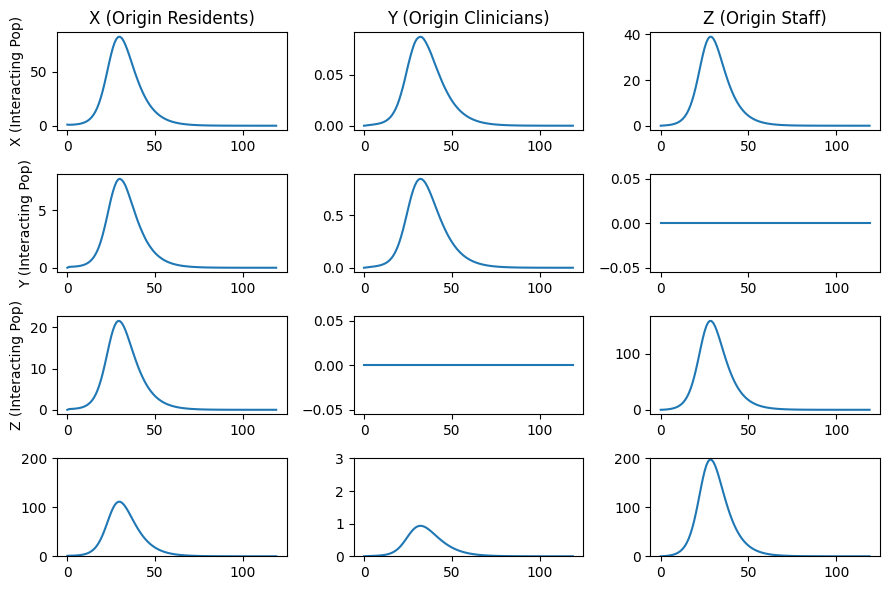

In [127]:
# Plot results
fig,axs = plt.subplots( 4,3, figsize=(9, 6))

solution = model()

times = solution.t

Ixx = solution.y[9]
Iyx = solution.y[10] 
Izx = solution.y[11] 

Ixy = solution.y[12]
Iyy = solution.y[13] 
Izy = solution.y[14] 

Ixz = solution.y[15]
Iyz = solution.y[16] 
Izz = solution.y[17] 

ax=axs[0,0]
ax.plot(Ixx)
ax.set_ylabel("X (Interacting Pop)")
ax.set_title("X (Origin Residents)")


ax=axs[0,1]
ax.plot(Iyx)
ax.set_title("Y (Origin Clinicians)")


ax=axs[0,2]
ax.plot(Izx)
ax.set_title("Z (Origin Staff)")


ax=axs[1,0]
ax.plot(Ixy)
ax.set_ylabel("Y (Interacting Pop)")

ax=axs[1,1]
ax.plot(Iyy)

ax=axs[1,2]
ax.plot(Izy)

ax=axs[2,0]
ax.plot(Ixz)
ax.set_ylabel("Z (Interacting Pop)")

ax=axs[2,1]
ax.plot(Iyz)

ax=axs[2,2]
ax.plot(Izz)

ax=axs[3,0]
ax.plot(Ixx + Ixy + Ixz)
ax.set_ylim(0,200)

ax=axs[3,1]
ax.plot(Iyx + Iyy + Iyz)
ax.set_ylim(0,3)

ax=axs[3,2]
ax.plot(Izx + Izy + Izz)
ax.set_ylim(0,200)

plt.tight_layout()

**Figure 2. (below)**
The average number of infected residents (blue), clinicians (green), and staff (orange) over a 24-month period.
The vertical dashed lines indicate in which month the number of infected peaks. 

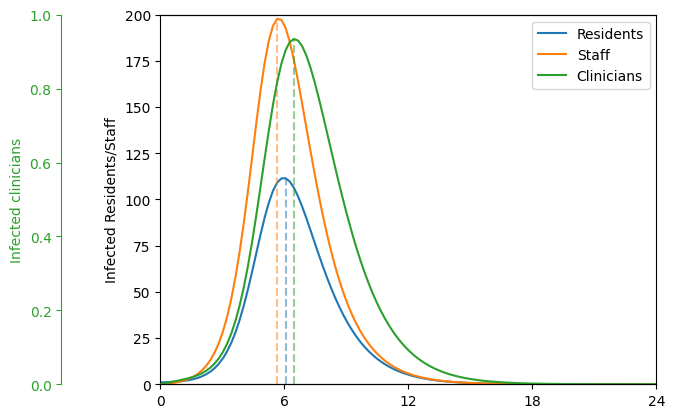

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("tab10",3)

fig, ax = plt.subplots()

# Main axis (center)
l1, = ax.plot(times, Ixx + Ixy + Ixz, color=colors[0],label="Residents")
l2, = ax.plot(times, Izx + Izy + Izz, color=colors[1],label="Staff")
ax.set_ylabel("Infected Residents/Staff")

# Twin axis (we're placing it on the LEFT, not the default right)
twin = ax.twinx()
l3, = twin.plot(times, Iyx + Iyy + Iyz, color=colors[2],label="Clinicians")

# Move twin axis to the left, with an offset
twin.spines["left"].set_position(("axes", -0.2))  # offset by 10% to the left
twin.spines["left"].set_color(colors[2])
twin.yaxis.set_ticks_position('left')
twin.yaxis.set_label_position('left')
twin.tick_params(axis='y', colors=colors[2])
twin.set_ylabel("Infected clinicians",color=colors[2])

# Hide the default right spine of the twin
twin.spines["right"].set_visible(False)
twin.set_ylim(0,1)


lines = [l1, l2, l3]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="upper right")


ax.plot( [times[np.argmax(Ixx + Ixy + Ixz)]]*2,   [0, np.max(Ixx + Ixy + Ixz)] ,color=colors[0], alpha=0.50, ls="--" )
ax.plot( [times[np.argmax(Izx + Izy + Izz)]]*2,   [0, np.max(Izx + Izy + Izz)] ,color=colors[1], alpha=0.50, ls="--" )
twin.plot( [times[np.argmax(Iyx + Iyy + Iyz)]]*2, [0, np.max(Iyx + Iyy + Iyz)] ,color=colors[2], alpha=0.50, ls="--" )

ax.set_ylim(0,200)
ax.set_xlim(0,24)
ax.set_xticks([0,6,12,18,24])

plt.show()

## Homework 
1.

